In [ ]:
import torch

In [ ]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

In [ ]:
path = untar_data(URLs.CAMVID)

In [ ]:
valid_fnames = (path/'valid.txt').read().split('\n')

In [ ]:
def ListSplitter(valid_items):
    def _inner(items):
        val_mask = tensor([o.name in valid_items for o in items])
        return [~val_mask,val_mask]
    return _inner

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, ImageBlock(cls=PILMask)),
                   get_items=get_image_files,
                   splitter=ListSplitter(valid_fnames),
                   get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}')

dbunch = camvid.databunch(path/"images", bs=8, #item_tfms=Resize(sz), 
                          batch_tfms=[*aug_transforms(size=(360,480)), Normalize.from_stats(*imagenet_stats)])

In [ ]:
dbunch = SegmentationDataBunch.from_label_func(path, bs=8,
    fnames = get_image_files(path/"images"), 
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',                                     
    codes = np.loadtxt(path/'codes.txt', dtype=str),                         
    batch_tfms=[*aug_transforms(size=(360,480)), Normalize.from_stats(*imagenet_stats)])

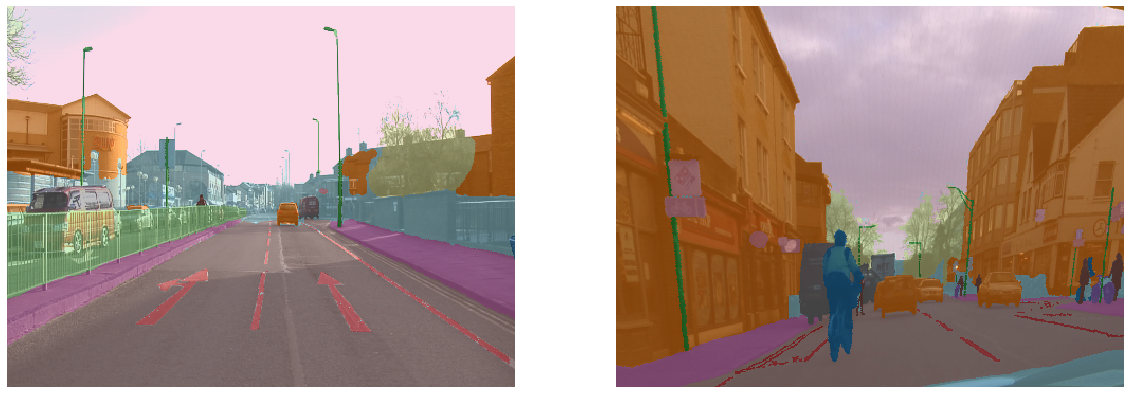

In [ ]:
dbunch.show_batch(max_n=2, rows=1, vmin=1, vmax=30, figsize=(20, 7))

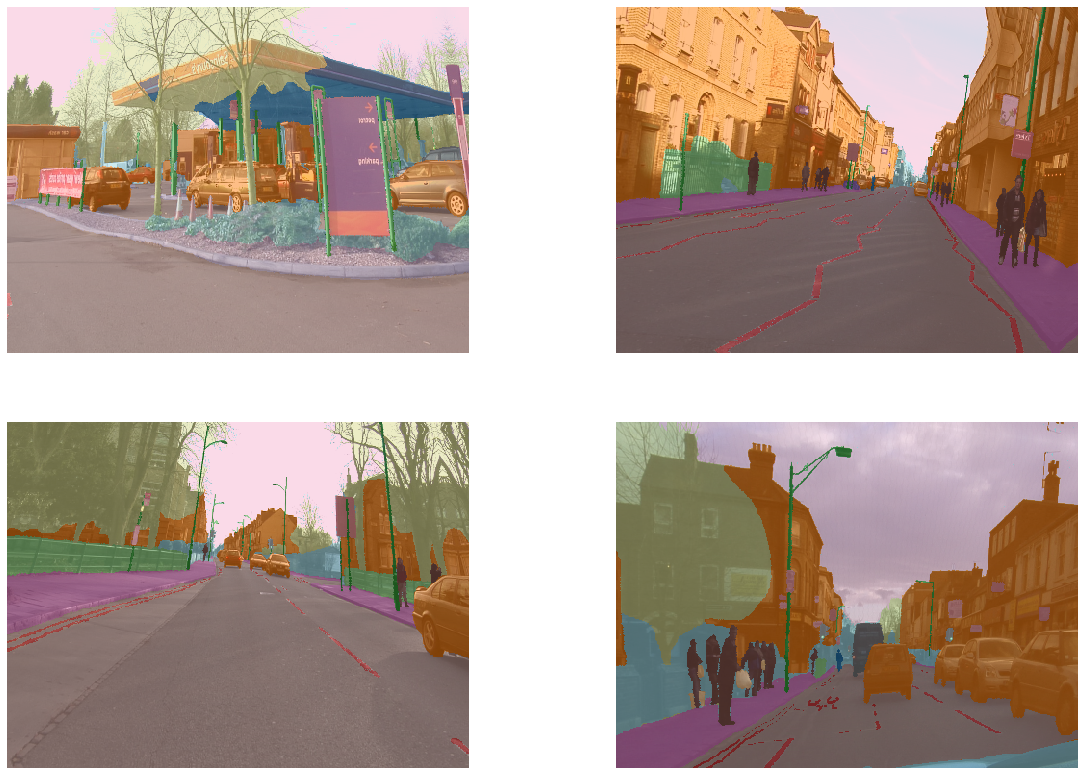

In [ ]:
dbunch.show_batch(max_n=4, vmin=1, vmax=30, figsize=(20, 14))

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
dbunch.vocab = codes

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
opt_func = partial(Adam, lr=3e-3, wd=0.01)#, eps=1e-8)

learn = unet_learner(dbunch, resnet34, loss_func=CrossEntropyLossFlat(axis=1), opt_func=opt_func, path=path, metrics=acc_camvid,
                     config = unet_config(norm_type=None), wd_bn_bias=True)

In [ ]:
get_c(dbunch)

32

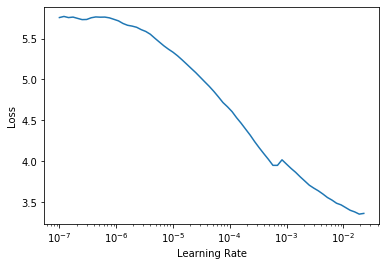

In [ ]:
learn.lr_find()

In [ ]:
lr= 3e-3
learn.freeze()

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9, wd=1e-2)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.200469,0.869627,0.769983,00:57
1,0.840649,0.809244,0.776909,00:47
2,0.716685,0.638332,0.838415,00:47
3,0.670508,0.551083,0.851559,00:47
4,0.664709,0.588863,0.849711,00:47
5,0.603191,0.502482,0.867659,00:47
6,0.592773,0.507730,0.869631,00:47
7,0.541870,0.540163,0.863005,00:47
8,0.531527,0.429516,0.878525,00:47
9,0.463456,0.345390,0.900292,00:47


In [ ]:
#export
class SegmentationDataBunch(DataBunch):    
    
    @classmethod
    @delegates(DataBunch.from_dblock)
    def from_label_func(cls, path, fnames, label_func, valid_pct=0.2, seed=None, codes=None, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`."
        dblock = DataBlock(blocks=(ImageBlock, ImageBlock(cls=PILMask)),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func)
        res = cls.from_dblock(dblock, fnames, path=path, **kwargs)
        if codes is not None: res.vocab = codes
        return res

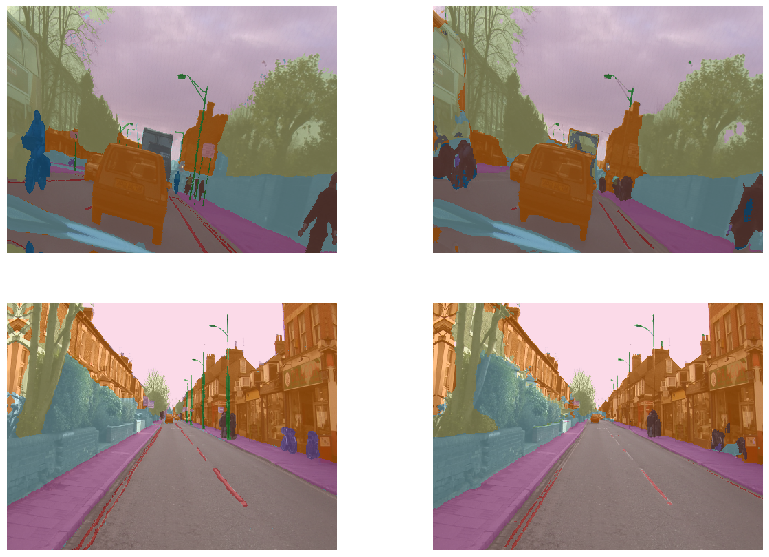

In [ ]:
learn.show_results(max_n=2, rows=2, vmin=1, vmax=30, figsize=(14, 10))

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1')
learn.unfreeze()

In [ ]:
#learn.opt.clear_state() #Not necessarily useful

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8, wd=1e-2)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.415170,0.350871,0.897328,00:42
1,0.405012,0.341905,0.899924,00:42
2,0.400426,0.330662,0.904413,00:42
3,0.385431,0.329282,0.904444,00:42
4,0.372985,0.322414,0.912512,00:42
5,0.366623,0.306477,0.916740,00:42
6,0.362156,0.298581,0.913030,00:42
7,0.343045,0.290931,0.919178,00:42
8,0.327369,0.295092,0.921611,00:42
9,0.334783,0.280629,0.922483,00:42


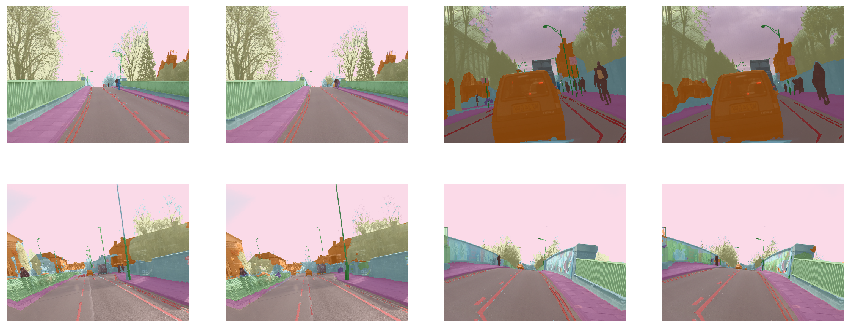

In [ ]:
learn.show_results(max_n=4, vmin=1, vmax=30, figsize=(15,6))